DONE:
- ignorer les valeurs nan dans le churn ("l'incertitude totale")
- filtrer l'age entre 20 et 59 ans
- entrainer sur une quantite de donnees (20%)
- utiliser tous les champs comme les features
- resoudre le probleme de desequilibre (RandomUnderSampler)

# Envouthe Churn Prediction

Envouthé souhaite réduire le % de churn et investir les efforts marketing sur les clients à risques (70% de risque de non renouvellement de l’abonnement) afin qu’ils renouvellent leur abonnement.

**Context**
- Les clients Envouthé peuvent souscrire à des abonnements mensuels, trimestriels, semestriels et annuels.
- A l’issue de la date de fin d’abonnement, le client doivent renouveler son abonnement.
- Dans le même lapse de temps, l'équipe marketing Envouthé envoie régulièrement un certain nombre d'emails promotionnels et d’emails d’informations.

**Objectif**
- Prédire le risque de churn pour les clients en fin d’abonnement

**Description du use case retenu:**
- En fonction du comportement des clients, l’algorithme va déduire un score de 0 à 1 (0 pas d'appétence au renouvellement ; 1 appétence au renouvellement forte)  
- si appétence > 0,7; pas d’action particulière
- si appétence entre 0,3 et 0,7 , c'est une visiteur tiède, le marketing pourra envoyer des offres marketing afin d’augmenter le % de renouvellement
- sinon: envoi d’une enquête satisfaction client

**Columns**
- id_subscriptionMain: id d'abonnement
- id_order: id de commande
- client_name: nom de client
- email: email de client
- box_name: nom de box
- subscriptions_type: type d'abonnement. Le numéro signifie que la durée de l’abonnement/la durée des échéances d’abonnement prévues dans le système. 
- month: la date du mois qui s'est écoulé depuis la date de début
- submain_state: le statut d'abonnement.
- product_attribute: l'attribut de produit	
- id: id de client
- last_name: nom de famille de client
- newsletter: si l'utilisateur inscrit le newsletter ou pas
- age: age de client
- beginning_date: date de debut d'abonnement
- ending_date: date de fin d'abonnement
- first_name: prenom de client
- abonnement_succ: si l'abonnement est active le mois suivant ou pas
- total_sub: nombre total d'abonnements
- abonnement_consec: la durée de l'abonnement effectif par rapport a la date de début
- churn: si l'abonnement va renouveller ou pas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import copy
import seaborn as sns
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


print(tf.__version__)

1.12.0


In [2]:
dataset = pd.read_csv('../../donnees/cleaned.csv')
dataset.head()

,id_subscriptionMain,id_order,client_name,email,box_name,subscriptions_type,month,submain_state,product_attribute,id,last_name,newsletter,age,beginning_date,ending_date,first_name,abonnement_succ,total_sub,abonnement_consec,churn
0,3504,25244,ji eun kim,01022972103@naver.com,Abonnement mensuel,12,01/03/2016,CANCELED,"Durée de l'abonnement :illimité, Fréquence d'e...",22650,ji eun,False,NaN,04/03/2016,31/05/2016,kim,True,1,1,No
1,3504,25244,ji eun kim,01022972103@naver.com,Abonnement mensuel,12,01/04/2016,CANCELED,"Durée de l'abonnement :illimité, Fréquence d'e...",22650,ji eun,False,NaN,04/03/2016,31/05/2016,kim,True,2,2,No
2,3504,25244,ji eun kim,01022972103@naver.com,Abonnement mensuel,12,01/05/2016,CANCELED,"Durée de l'abonnement :illimité, Fréquence d'e...",22650,ji eun,False,NaN,04/03/2016,31/05/2016,kim,False,3,3,Yes
3,19583,38629,Jain Elodie,04f1994@gmail.com,Abonnement mensuel,17,01/03/2017,CANCELED,"Durée de l'abonnement :illimité, Fréquence d'e...",24551,Jain,False,25.0,01/03/2017,31/07/2018,Elodie,True,1,1,No
4,19583,38629,Jain Elodie,04f1994@gmail.com,Abonnement mensuel,17,01/04/2017,CANCELED,"Durée de l'abonnement :illimité, Fréquence d'e...",24551,Jain,False,25.0,01/03/2017,31/07/2018,Elodie,True,2,2,No


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107404 entries, 0 to 107403
Data columns (total 20 columns):
id_subscriptionMain    107404 non-null int64
id_order               107404 non-null int64
client_name            107404 non-null object
email                  107404 non-null object
box_name               107404 non-null object
subscriptions_type     107404 non-null int64
month                  107404 non-null object
submain_state          107404 non-null object
product_attribute      107404 non-null object
id                     107404 non-null int64
last_name              107404 non-null object
newsletter             107404 non-null bool
age                    45427 non-null float64
beginning_date         107404 non-null object
ending_date            107404 non-null object
first_name             107404 non-null object
abonnement_succ        105906 non-null object
total_sub              107404 non-null int64
abonnement_consec      107404 non-null int64
churn                  

In [4]:
# vérifier le nombre de valeurs nulles
dataset.isnull().sum()

id_subscriptionMain        0
id_order                   0
client_name                0
email                      0
box_name                   0
subscriptions_type         0
month                      0
submain_state              0
product_attribute          0
id                         0
last_name                  0
newsletter                 0
age                    61977
beginning_date             0
ending_date                0
first_name                 0
abonnement_succ         1498
total_sub                  0
abonnement_consec          0
churn                   1498
dtype: int64

In [5]:
# vérifier le nombre de classifications sur chaque champ
dataset.nunique()

id_subscriptionMain    12004
id_order               12004
client_name             8532
email                   8588
box_name                   2
subscriptions_type        67
month                     92
submain_state              4
product_attribute          2
id                      8588
last_name               5370
newsletter                 2
age                       68
beginning_date          2097
ending_date               83
first_name              5536
abonnement_succ            2
total_sub                132
abonnement_consec        132
churn                      2
dtype: int64

In [6]:
dataset.describe()

,id_subscriptionMain,id_order,subscriptions_type,id,age,total_sub,abonnement_consec
count,107404.000000,107404.000000,107404.000000,107404.000000,45427.000000,107404.000000,107404.000000
mean,16262.689043,27203.059616,16.768007,19204.507895,32.881722,12.494404,11.290529
std,7666.235285,18430.199217,13.449215,15097.731944,15.125776,13.119078,12.402974
min,7.000000,2.000000,12.000000,1.000000,0.000000,1.000000,1.000000
25%,10864.750000,11138.000000,12.000000,6078.000000,27.000000,4.000000,3.000000
50%,16747.500000,22540.000000,12.000000,14325.000000,32.000000,8.000000,8.000000
75%,22013.000000,43844.000000,12.000000,34850.000000,41.000000,15.000000,13.000000
max,29677.000000,60194.000000,80.000000,47781.000000,119.000000,132.000000,132.000000


## data exploration

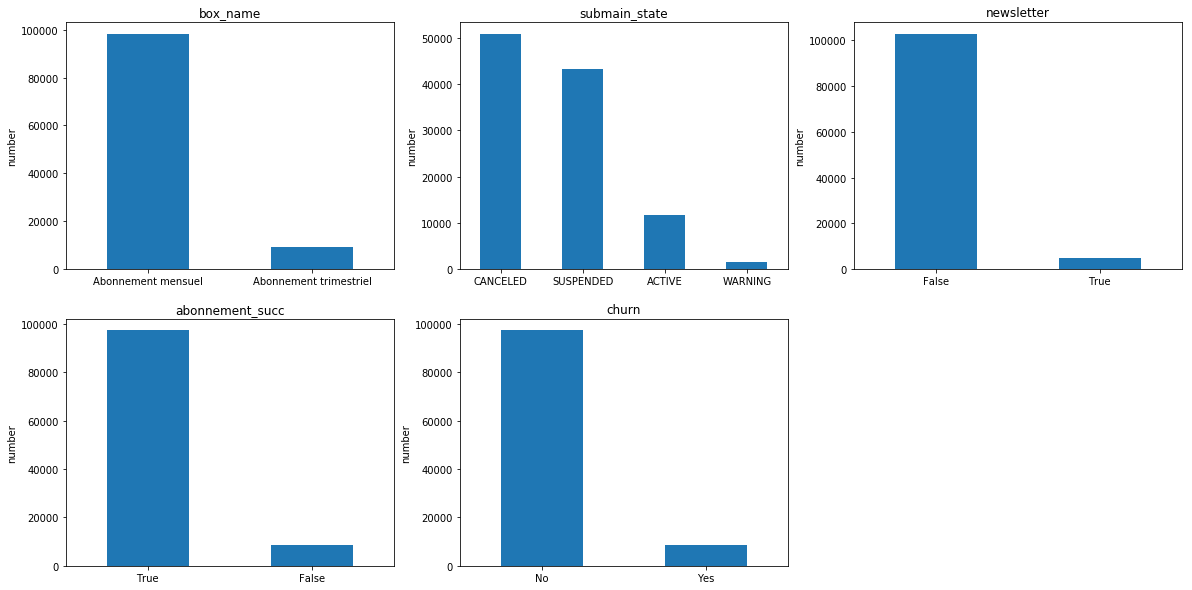

In [7]:
fig = plt.figure()
fig.set_size_inches(20, 10)

# box_name
plt.subplot2grid((2,3),(0,0))
dataset.box_name.value_counts().plot(kind='bar')
plt.title(u"box_name")
plt.ylabel(u"number")
pl.xticks(rotation=360)

# submain_state
plt.subplot2grid((2,3),(0,1))
dataset.submain_state.value_counts().plot(kind='bar')
plt.title(u"submain_state")
plt.ylabel(u"number")
pl.xticks(rotation=360)

# newsletter
plt.subplot2grid((2,3),(0,2))
dataset.newsletter.value_counts().plot(kind='bar')
plt.title(u"newsletter")
plt.ylabel(u"number")
pl.xticks(rotation=360)

# abonnement_succ
plt.subplot2grid((2,3),(1,0))
dataset.abonnement_succ.value_counts().plot(kind='bar')
plt.title(u"abonnement_succ")
plt.ylabel(u"number")
pl.xticks(rotation=360)

# churn
plt.subplot2grid((2,3),(1,1))
dataset.churn.value_counts().plot(kind='bar')
plt.title(u"churn")
plt.ylabel(u"number")
pl.xticks(rotation=360)

plt.show()

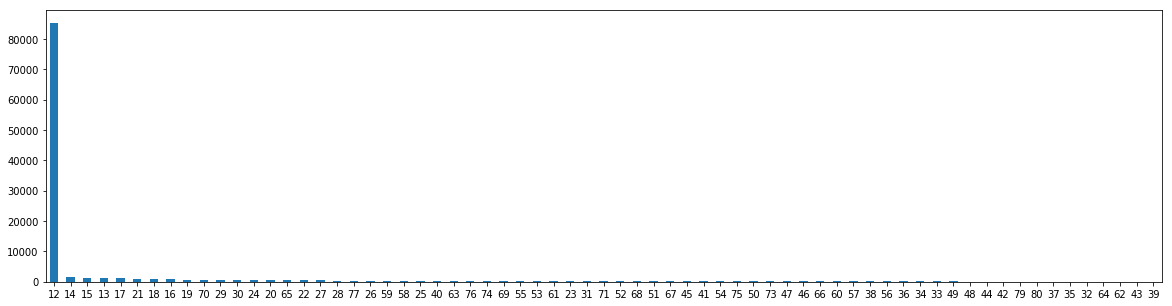

In [8]:
# subscriptions_type
fig = plt.figure()
fig.set_size_inches(20,5)

dataset.subscriptions_type.value_counts().plot(kind='bar')
pl.xticks(rotation=360)
plt.show()

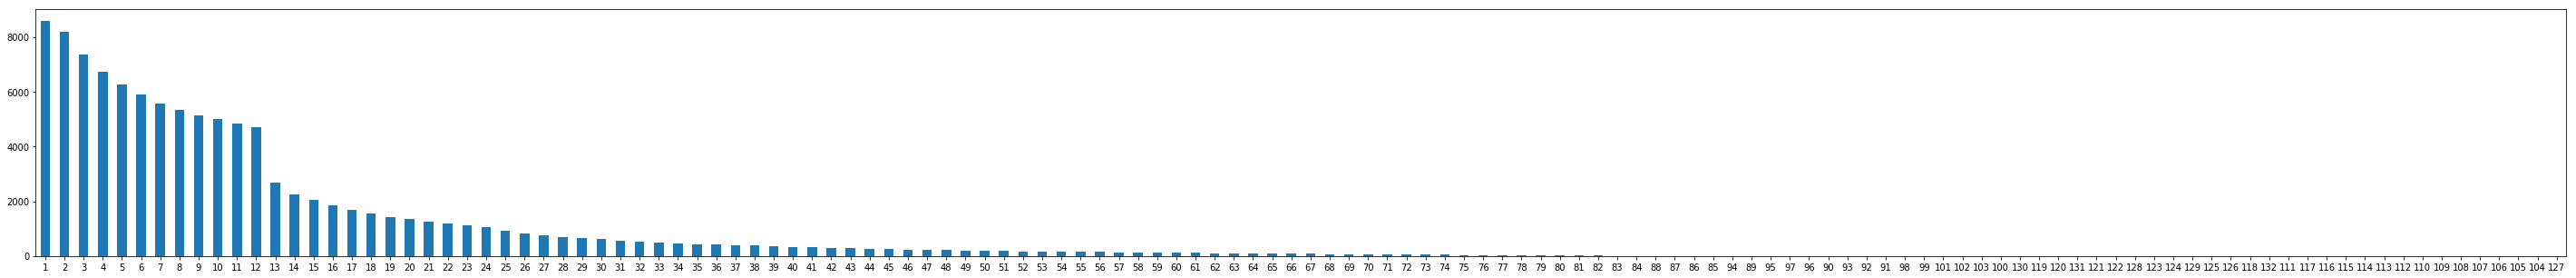

In [9]:
# total_sub
fig = plt.figure()
fig.set_size_inches(50,5)

dataset.total_sub.value_counts().plot(kind='bar')
pl.xticks(rotation=360)
plt.show()

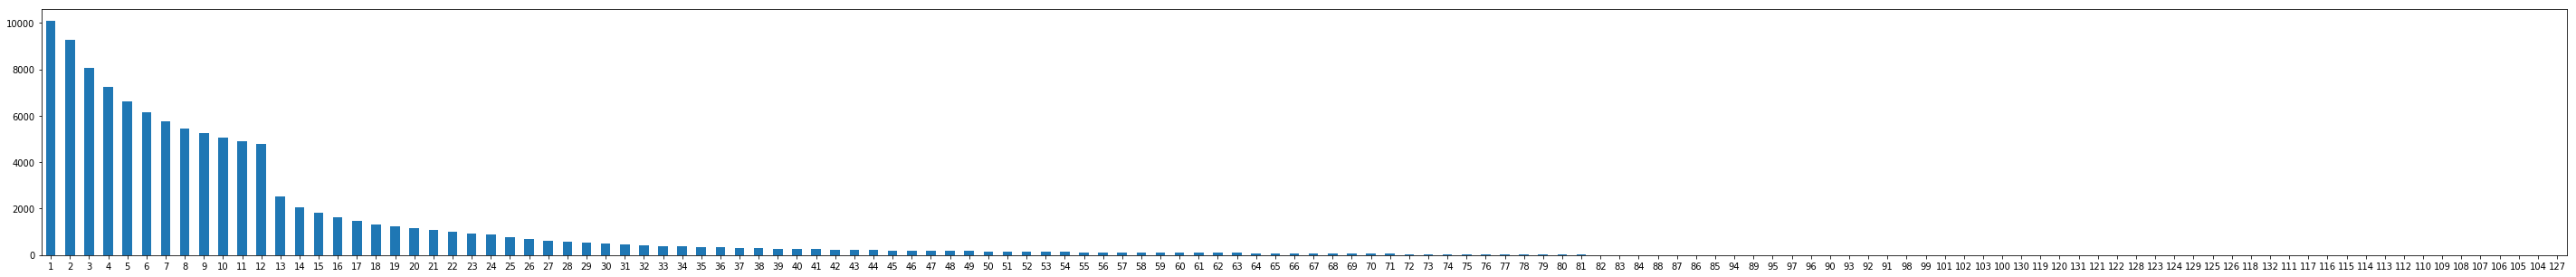

In [10]:
# abonnement_consec
fig = plt.figure()
fig.set_size_inches(50,5)

dataset.abonnement_consec.value_counts().plot(kind='bar')
pl.xticks(rotation=360)
plt.show()

<Figure size 864x864 with 0 Axes>

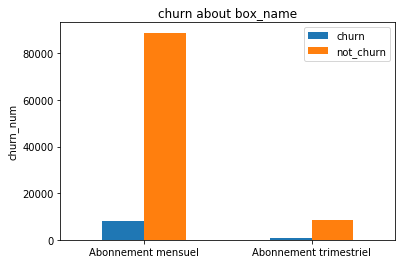

In [11]:
# churn about box_name
fig = plt.figure()
fig.set_size_inches(12,12)

churn = dataset.box_name[dataset.churn == 'Yes'].value_counts()
non_churn = dataset.box_name[dataset.churn == 'No'].value_counts()
dataset1 = pd.DataFrame({u"churn":churn,u"not_churn":non_churn})

dataset1.plot(kind="bar", stacked=False)
plt.title(u"churn about box_name")
plt.ylabel(u"churn_num")
pl.xticks(rotation=360)

plt.show()

<Figure size 864x864 with 0 Axes>

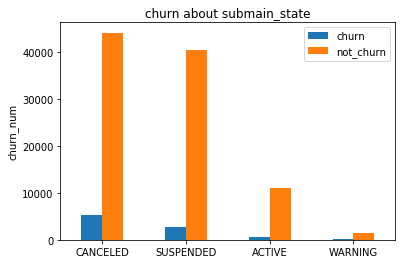

In [12]:
# churn about submain_state
fig = plt.figure()
fig.set_size_inches(12,12)

churn = dataset.submain_state[dataset.churn == 'Yes'].value_counts()
non_churn = dataset.submain_state[dataset.churn == 'No'].value_counts()
dataset2 = pd.DataFrame({u"churn":churn,u"not_churn":non_churn})

dataset2.plot(kind="bar", stacked=False)
plt.title(u"churn about submain_state")
plt.ylabel(u"churn_num")
pl.xticks(rotation=360)

plt.show()

<Figure size 864x864 with 0 Axes>

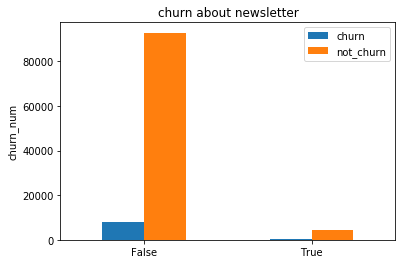

In [14]:
# churn about newsletter
fig = plt.figure()
fig.set_size_inches(12,12)

churn = dataset.newsletter[dataset.churn == 'Yes'].value_counts()
non_churn = dataset.newsletter[dataset.churn == 'No'].value_counts()
dataset2 = pd.DataFrame({u"churn":churn,u"not_churn":non_churn})

dataset2.plot(kind="bar", stacked=False)
plt.title(u"churn about newsletter")
plt.ylabel(u"churn_num")
pl.xticks(rotation=360)

plt.show()

<Figure size 864x864 with 0 Axes>

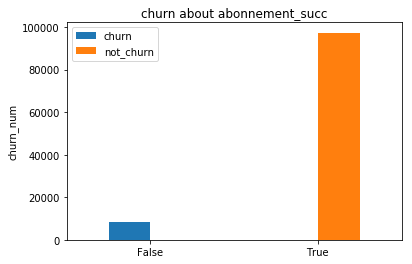

In [15]:
# churn about abonnement_succ
fig = plt.figure()
fig.set_size_inches(12,12)

churn = dataset.abonnement_succ[dataset.churn == 'Yes'].value_counts()
non_churn = dataset.abonnement_succ[dataset.churn == 'No'].value_counts()
dataset2 = pd.DataFrame({u"churn":churn,u"not_churn":non_churn})

dataset2.plot(kind="bar", stacked=False)
plt.title(u"churn about abonnement_succ")
plt.ylabel(u"churn_num")
pl.xticks(rotation=360)

plt.show()

## data preprocessing

In [16]:
df = copy.deepcopy(dataset)

# supprimer les champs
df = df.drop(columns='product_attribute') # champ inutile
df = df.drop('first_name', axis = 1) # c'est le meme que le champ client_name
df = df.drop('last_name', axis = 1) # c'est le meme que le champ client_name

# supprimer les duplicates
df = df.drop_duplicates(df.columns, keep='last') 

df.head()

,id_subscriptionMain,id_order,client_name,email,box_name,subscriptions_type,month,submain_state,id,newsletter,age,beginning_date,ending_date,abonnement_succ,total_sub,abonnement_consec,churn
0,3504,25244,ji eun kim,01022972103@naver.com,Abonnement mensuel,12,01/03/2016,CANCELED,22650,False,NaN,04/03/2016,31/05/2016,True,1,1,No
1,3504,25244,ji eun kim,01022972103@naver.com,Abonnement mensuel,12,01/04/2016,CANCELED,22650,False,NaN,04/03/2016,31/05/2016,True,2,2,No
2,3504,25244,ji eun kim,01022972103@naver.com,Abonnement mensuel,12,01/05/2016,CANCELED,22650,False,NaN,04/03/2016,31/05/2016,False,3,3,Yes
3,19583,38629,Jain Elodie,04f1994@gmail.com,Abonnement mensuel,17,01/03/2017,CANCELED,24551,False,25.0,01/03/2017,31/07/2018,True,1,1,No
4,19583,38629,Jain Elodie,04f1994@gmail.com,Abonnement mensuel,17,01/04/2017,CANCELED,24551,False,25.0,01/03/2017,31/07/2018,True,2,2,No


In [17]:
# definir les donnees numeriques et les donnees categoriques
date_col = ['month', 'beginning_date', 'ending_date']
bool_col = ['newsletter', 'abonnement_succ']
numerique = ['subscriptions_type', 'age', 'abonnement_consec', 'total_sub']
categorique = [i for i in df.columns.values.tolist() if i not in ['id_subscriptionMain', 'id', 'id_order', 'month', 'beginning_date', 'ending_date', \
                                                                  'newsletter', 'abonnement_succ', 'subscriptions_type', 'age', 'abonnement_consec', 'total_sub']]

x_date = df[date_col]
x_bool = df[bool_col]
x_numerique = df[numerique]
x_categorique = df[categorique]

print(x_date.shape, x_bool.shape, x_numerique.shape, x_categorique.shape)

(107404, 3) (107404, 2) (107404, 4) (107404, 5)


**preprocessing sur les dates**

In [18]:
# verifier les valeurs nulles
print(x_date.isnull().sum())

month             0
beginning_date    0
ending_date       0
dtype: int64


In [19]:
# extraire le jours et le mois
df['month'] = pd.to_datetime(df['month'])
df['beginning_date'] = pd.to_datetime(df['beginning_date'])
df['ending_date'] = pd.to_datetime(df['ending_date'])

# on ignore le jour, car c'est toujours le 1 du mois
df['year_pass'] = df['month'].dt.year
df['month_pass'] = df['month'].dt.day # extraire le jours ici, car le format du champ month inverse le mois et le jours

df['begin_year'] = df['beginning_date'].dt.year
df['begin_month'] = df['beginning_date'].dt.month
df['begin_day'] = df['beginning_date'].dt.day

df['end_year'] = df['ending_date'].dt.year
df['end_month'] = df['ending_date'].dt.month
df['end_day'] = df['ending_date'].dt.day

In [20]:
#supprimer les champs month et ending_month
df = df.drop(columns=['month','beginning_date', 'ending_date'])

df.head()

,id_subscriptionMain,id_order,client_name,email,box_name,subscriptions_type,submain_state,id,newsletter,age,...,abonnement_consec,churn,year_pass,month_pass,begin_year,begin_month,begin_day,end_year,end_month,end_day
0,3504,25244,ji eun kim,01022972103@naver.com,Abonnement mensuel,12,CANCELED,22650,False,NaN,...,1,No,2016,3,2016,4,3,2016,5,31
1,3504,25244,ji eun kim,01022972103@naver.com,Abonnement mensuel,12,CANCELED,22650,False,NaN,...,2,No,2016,4,2016,4,3,2016,5,31
2,3504,25244,ji eun kim,01022972103@naver.com,Abonnement mensuel,12,CANCELED,22650,False,NaN,...,3,Yes,2016,5,2016,4,3,2016,5,31
3,19583,38629,Jain Elodie,04f1994@gmail.com,Abonnement mensuel,17,CANCELED,24551,False,25.0,...,1,No,2017,3,2017,1,3,2018,7,31
4,19583,38629,Jain Elodie,04f1994@gmail.com,Abonnement mensuel,17,CANCELED,24551,False,25.0,...,2,No,2017,4,2017,1,3,2018,7,31


**preprocessing sur les donnees numeriques**

In [21]:
df2 = copy.deepcopy(df)
# df = copy.deepcopy(df2)

In [22]:
# verifier les valeurs nulles
print(x_numerique.isnull().sum())

subscriptions_type        0
age                   61977
abonnement_consec         0
total_sub                 0
dtype: int64


In [23]:
df.age.min(), df.age.max()

(0.0, 119.0)

In [24]:
# transformer l'age en tranche d'age
df.loc[(df.age<10), 'age'] = 0 # age < 10 ans
df.loc[(df.age>=10) & (df.age<20), 'age'] = 1 # age entre 10 et 19 ans
df.loc[(df.age>=20) & (df.age<30), 'age'] = 2 # age entre 20 et 29 ans
df.loc[(df.age>=30) & (df.age<40), 'age'] = 3 # age entre 30 et 39 ans
df.loc[(df.age>=40) & (df.age<50), 'age'] = 4 # age entre 40 et 49 ans
df.loc[(df.age>=50) & (df.age<60), 'age'] = 5 # age entre 50 et 59 ans
df.loc[(df.age>=60) & (df.age<70), 'age'] = 6 # age entre 60 et 69 ans
df.loc[(df.age>=70) & (df.age<80), 'age'] = 7 # age entre 70 et 79 ans
df.loc[(df.age>=80) & (df.age<90), 'age'] = 8 # age entre 80 et 89 ans
df.loc[(df.age>=90) & (df.age<100), 'age'] = 9 # age entre 90 et 99 ans
df.loc[(df.age>=100), 'age'] = 10 # age > 100 ans
df.loc[(df.age.isnull()), 'age'] = 11 # not have age

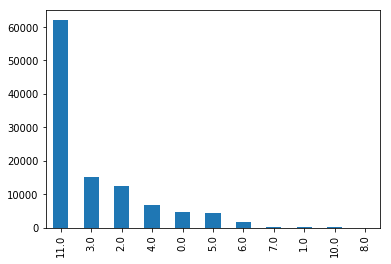

In [25]:
fig = plt.figure()

df.age.value_counts().plot(kind='bar')
plt.show()

In [26]:
print(df.shape)
# filtrer les clients qui ont l'age entre 20 et 59, et les valuers nulles
df = df[((df.age >= 2) & (df.age <= 5)) | (df.age == 11)]
print(df.shape)

(107404, 22)
(100864, 22)


In [27]:
# on peut completer les valeurs nulles par median, mais il y a nombreux valeurs nulles sur le champ age, cela va prendre beaucoup de bruit
# sinon on prend en compte les valeurs nulles comme une type
# alors, on va transformer le champ age par deux valeurs: have age et not have age

df.loc[df.age != 11, 'age'] = 1
df.loc[df.age == 11, 'age'] = 0
df.age = df.age.astype(int)

In [28]:
df.age.value_counts()

0    61977
1    38887
Name: age, dtype: int64

**preprocessing sur les champs categoriques**

In [29]:
df3 = copy.deepcopy(df)
# df = copy.deepcopy(df3)

In [30]:
# verifier les valeurs nulles
print(x_categorique.isnull().sum())

client_name         0
email               0
box_name            0
submain_state       0
churn            1498
dtype: int64


In [31]:
# supprimer les champs qui ont trop de categoriques ou qui ne sont pas utiles pour la prediction de churn
df = df.drop(columns=['client_name','email'])

In [32]:
print(df['box_name'].unique())
print(df['submain_state'].unique())
print(df['churn'].unique())

['Abonnement mensuel' 'Abonnement trimestriel']
['CANCELED' 'SUSPENDED' 'ACTIVE' 'WARNING']
['No' 'Yes' nan]


In [33]:
# convertir les valeurs categorique en valeurs numeriques

# box_name
df['box_name'] = df['box_name'].replace(['Abonnement mensuel', 'Abonnement trimestriel'],[0,1])

# submain_state
df['submain_state'] = df['submain_state'].replace(['CANCELED','SUSPENDED','ACTIVE','WARNING'],[0,1,2,3])

# churn
df = df.dropna(subset=["churn"]) # l'incertitude totale
df['churn'] = df['churn'].replace(['No','Yes'],[0,1]) # cas churn et cas non churn

df.head()

,id_subscriptionMain,id_order,box_name,subscriptions_type,submain_state,id,newsletter,age,abonnement_succ,total_sub,abonnement_consec,churn,year_pass,month_pass,begin_year,begin_month,begin_day,end_year,end_month,end_day
0,3504,25244,0,12,0,22650,False,0,True,1,1,0,2016,3,2016,4,3,2016,5,31
1,3504,25244,0,12,0,22650,False,0,True,2,2,0,2016,4,2016,4,3,2016,5,31
2,3504,25244,0,12,0,22650,False,0,False,3,3,1,2016,5,2016,4,3,2016,5,31
3,19583,38629,0,17,0,24551,False,1,True,1,1,0,2017,3,2017,1,3,2018,7,31
4,19583,38629,0,17,0,24551,False,1,True,2,2,0,2017,4,2017,1,3,2018,7,31


**preprocessing sur les donnees boolean**

In [34]:
df1 = copy.deepcopy(df)
# df = copy.deepcopy(df1)

In [35]:
# verifier les valeurs nulles
x_bool = df[bool_col]
print(x_bool.isnull().sum())

newsletter         0
abonnement_succ    0
dtype: int64


In [36]:
df['newsletter'] = df['newsletter'].replace([False,True],[0,1])
df['abonnement_succ'] = df['abonnement_succ'].replace([False, True], [0,1])

df.head()

,id_subscriptionMain,id_order,box_name,subscriptions_type,submain_state,id,newsletter,age,abonnement_succ,total_sub,abonnement_consec,churn,year_pass,month_pass,begin_year,begin_month,begin_day,end_year,end_month,end_day
0,3504,25244,0,12,0,22650,0,0,1,1,1,0,2016,3,2016,4,3,2016,5,31
1,3504,25244,0,12,0,22650,0,0,1,2,2,0,2016,4,2016,4,3,2016,5,31
2,3504,25244,0,12,0,22650,0,0,0,3,3,1,2016,5,2016,4,3,2016,5,31
3,19583,38629,0,17,0,24551,0,1,1,1,1,0,2017,3,2017,1,3,2018,7,31
4,19583,38629,0,17,0,24551,0,1,1,2,2,0,2017,4,2017,1,3,2018,7,31


**heat map pour la correlation**

In [37]:
# definir les features et le label
ids = ['id_subscriptionMain', 'id', 'id_order',]
label = ['churn']

features = [i for i in df.columns.values.tolist() if i not in ['id_subscriptionMain', 'id', 'id_order', 'churn']]
data = [j for j in df.columns.values.tolist() if j not in ['id_subscriptionMain', 'id', 'id_order']]

df_id = df[ids] # id_subscriptionMain, id_order et id
df_data = df[data] # features + label
df_features = df[features] # tous les champs sauf ids et churn
df_label = df[label] # churn

In [38]:
df_id.shape, df_data.shape, df_features.shape, df_label.shape

((99375, 3), (99375, 17), (99375, 16), (99375, 1))

In [39]:
df = pd.concat((df_id, df_features, df_label),axis=1)
df.head()

,id_subscriptionMain,id,id_order,box_name,subscriptions_type,submain_state,newsletter,age,abonnement_succ,total_sub,abonnement_consec,year_pass,month_pass,begin_year,begin_month,begin_day,end_year,end_month,end_day,churn
0,3504,22650,25244,0,12,0,0,0,1,1,1,2016,3,2016,4,3,2016,5,31,0
1,3504,22650,25244,0,12,0,0,0,1,2,2,2016,4,2016,4,3,2016,5,31,0
2,3504,22650,25244,0,12,0,0,0,0,3,3,2016,5,2016,4,3,2016,5,31,1
3,19583,24551,38629,0,17,0,0,1,1,1,1,2017,3,2017,1,3,2018,7,31,0
4,19583,24551,38629,0,17,0,0,1,1,2,2,2017,4,2017,1,3,2018,7,31,0


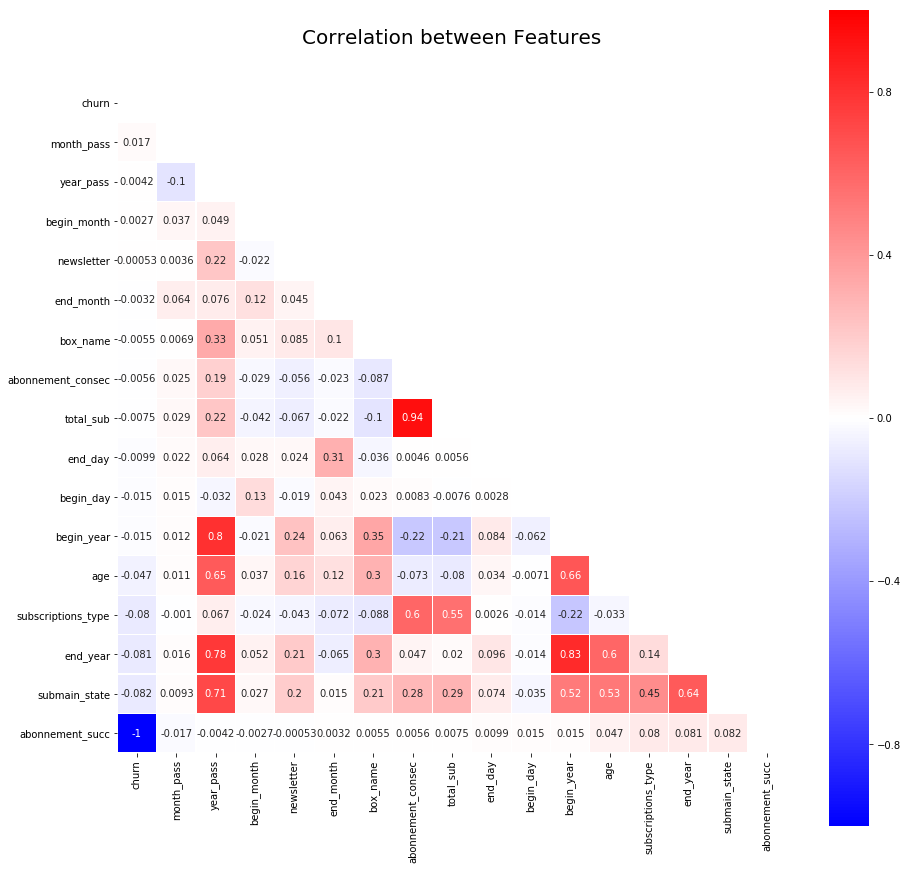

In [40]:
# Heat map pour la correlation entre les features
colormap = plt.cm.bwr
# colormap.set_size
plt.figure(figsize=(15,15))
plt.title('Correlation between Features', y=1.05, size = 20)

k = len(df_data)

# Generate a mask for the upper triangle
corr = df_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cols = corr.nlargest(k, 'churn')['churn'].index
cm = np.corrcoef(df[cols].values.T)

# heatmap
sns.heatmap(cm,
            linewidths=0.1, 
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white', 
            annot=True,
           mask = mask,
           yticklabels=cols.values, 
            xticklabels=cols.values)

plt.show()

In [41]:
# regarder la correlation avec le champ churn
df_data.corr()["churn"].sort_values(ascending=False)

churn                 1.000000
month_pass            0.016622
year_pass             0.004225
begin_month           0.002746
newsletter            0.000525
end_month            -0.003219
box_name             -0.005476
abonnement_consec    -0.005617
total_sub            -0.007498
end_day              -0.009936
begin_day            -0.014614
begin_year           -0.015306
age                  -0.047290
subscriptions_type   -0.080168
end_year             -0.081279
submain_state        -0.082284
abonnement_succ      -1.000000
Name: churn, dtype: float64

In [42]:
# le champ abonnement_succ est totalement negativement correle, on ne le considere pas comme le feature
df = df.drop(columns='abonnement_succ')

**normalisation**

In [43]:
df.iloc[:,3:-1] = normalize(df.iloc[:,3:-1])

df.head()

,id_subscriptionMain,id,id_order,box_name,subscriptions_type,submain_state,newsletter,age,total_sub,abonnement_consec,year_pass,month_pass,begin_year,begin_month,begin_day,end_year,end_month,end_day,churn
0,3504,22650,25244,0.0,0.003436,0.0,0.0,0.000000,0.000286,0.000286,0.577323,0.000859,0.577323,0.001145,0.000859,0.577323,0.001432,0.008877,0
1,3504,22650,25244,0.0,0.003436,0.0,0.0,0.000000,0.000573,0.000573,0.577322,0.001145,0.577322,0.001145,0.000859,0.577322,0.001432,0.008877,0
2,3504,22650,25244,0.0,0.003436,0.0,0.0,0.000000,0.000859,0.000859,0.577322,0.001432,0.577322,0.001145,0.000859,0.577322,0.001432,0.008877,1
3,19583,24551,38629,0.0,0.004865,0.0,0.0,0.000286,0.000286,0.000286,0.577224,0.000859,0.577224,0.000286,0.000859,0.577510,0.002003,0.008872,0
4,19583,24551,38629,0.0,0.004865,0.0,0.0,0.000286,0.000572,0.000572,0.577223,0.001145,0.577223,0.000286,0.000859,0.577510,0.002003,0.008872,0


## machine learning
**definir les features**

In [44]:
df5 = copy.deepcopy(df)
# df = copy.deepcopy(df5)

In [45]:
ids = ['id_subscriptionMain', 'id', 'id_order']
label = ['churn']

features = [i for i in df.columns.values.tolist() if i not in ['id_subscriptionMain', 'id', 'id_order', 'churn']]
data = [j for j in df.columns.values.tolist() if j not in ['id_subscriptionMain', 'id', 'id_order']]

df_id = df[ids] # id_subscriptionMain, id_order et id
df_data = df[data] # features + label
df_features = df[features] # tous les champs sauf ids et churn
df_label = df[label] # churn

In [46]:
# utiliser ExtraTreesClassifier pour calculer l'importance de features
from sklearn.ensemble import ExtraTreesClassifier

df_imp = df_features

clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(df_imp, df['churn'])

In [47]:
feats = pd.DataFrame()
feats['feature'] = df_imp.columns
feats['importance'] = clf.feature_importances_

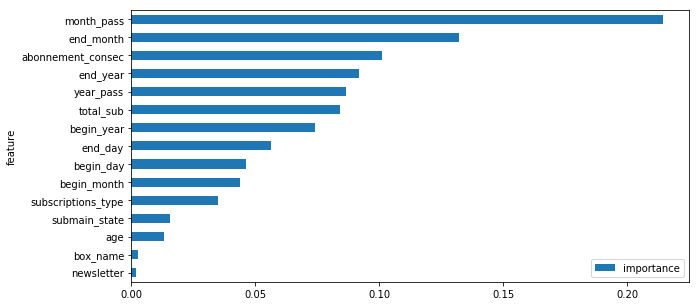

In [48]:
feats.sort_values(by=['importance'], ascending=True, inplace=True)
feats.set_index('feature', inplace=True)

feats.plot(kind='barh', figsize=(10, 5))

methode 1: choisir les features les plus importants

In [ ]:
# # utiliser SelectFromModel a chosir les features les plus importants
# from sklearn.feature_selection import SelectFromModel

# mdl = SelectFromModel(clf, prefit=True)
# df_imp_new = mdl.transform(df_imp)

# print(df_imp_new.shape)

In [ ]:
# indices = mdl.get_support(indices=False)
# df_new = df_imp.loc[:, indices]
# # df_new.head()
# df = pd.concat((df.iloc[:, :3], df_new, df['churn']), axis=1)
# df.head()

methode 2: utiliser tous les champs comme features

In [49]:
train_data = df.columns.values.tolist()
train_features = [i for i in train_data if i not in ['id_subscriptionMain', 'id', 'id_order', 'churn']]

df = df[train_data]
df_features = df[train_features]

**splitting data**

In [50]:
df6 = copy.deepcopy(df)
# df = copy.deepcopy(df6)

In [51]:
# echantilloner au hasard une quantite des données, car svm coute trop de temps si la quantitie des donnees est trop grande.
print(df.shape)
df = df.sample(frac=0.2, random_state=70, axis=0)

print(df.shape)

(99375, 19)
(19875, 19)


In [52]:
# taille train : test = 7:3
train,test = train_test_split(df,test_size = .3 ,random_state = 40)

test_id_sub = test['id_subscriptionMain'].astype(int)
# test_id_ord = test['id_order'].astype(int)
# test_id_cust = test['id'].astype(int)

cols = [i for i in df_features.columns.values.tolist()]

train_X = train[cols]
train_Y = train['churn']
test_X  = test[cols]
test_Y  = test['churn']

X = pd.concat((train_X, test_X), axis=0)
y = pd.concat((train_Y, test_Y), axis=0)

print(train_Y.value_counts())

0    12802
1     1110
Name: churn, dtype: int64


**equilibrer les donnees**

on trouve que le churn contient trop de valeur 0, on va donc equilibrer les donnees

In [53]:
train_X = train[cols]
train_Y = train['churn']

data_cols = [i for i in train_X.columns.values.tolist()]

X_sampled = train_X
y_sampled = train_Y

print(pd.Series(y_sampled).value_counts())

# Under Sampling pour resoudre le probleme de desequilibre
from imblearn.under_sampling import RandomUnderSampler
rus= RandomUnderSampler() 
X_resampled, y_resampled = rus.fit_sample(X_sampled, y_sampled)

print(pd.Series(y_resampled).value_counts())

0    12802
1     1110
Name: churn, dtype: int64
1    1110
0    1110
dtype: int64


Using TensorFlow backend.


In [54]:
train_X = pd.DataFrame(X_resampled, columns=data_cols)
train_Y = pd.DataFrame(y_resampled, columns=['churn'])

**logistic regression**

In [55]:
# Logistic Regression classifier
LR = LogisticRegression(solver='lbfgs', multi_class='auto')
LR.fit(train_X, train_Y)

# prediction

# 2 prediction type
y_pred_lr = LR.predict(test_X) 
y_pred_prob_lr = LR.predict_proba(test_X) # Predict probabilities

# accuracy_score
LR_accuracy = accuracy_score(test_Y,y_pred_lr)*100
print ("LR Accuracy score = {}".format(LR_accuracy))

LR Accuracy score = 31.762535636424616


D:\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
print(np.unique(test_Y))
print(np.unique(y_pred_lr))

[0 1]
[0 1]


In [57]:
# confusion matrix
lr_confsmat = confusion_matrix(test_Y, y_pred_lr, labels=[0,1])

print("confusion matrix")
print(lr_confsmat)

confusion matrix
[[1512 3977]
 [  92  382]]


In [58]:
# classification report

# precision: how many classifications are given correctly
# recall: the correctness of this classification. The greater the recall rate, the better the recognition of this class.
# f1-socre: 2*precision*recall/(precision+recall)
# support: actual number of samples per class

lr_clsreport = classification_report(test_Y, y_pred_lr)

print("classification_report(left: labels):")
print(lr_clsreport)

classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.94      0.28      0.43      5489
           1       0.09      0.81      0.16       474

    accuracy                           0.32      5963
   macro avg       0.52      0.54      0.29      5963
weighted avg       0.87      0.32      0.41      5963



In [59]:
# visualisation le resultat de prediction
y_pred_prob_lr_0 = y_pred_prob_lr[:,0]
y_pred_prob_lr_1 = y_pred_prob_lr[:,1]

result_lr = pd.DataFrame({'id_subscriptionMain':test_id_sub.values, 'churn_reel':test_Y, 'churn_pred':y_pred_lr.astype(np.int32), \
                          'churn_pred_prob':y_pred_prob_lr_1})
result_lr.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
47601,27416,0,1,0.500052
19715,21520,0,1,0.500017
66653,14402,0,1,0.500395
33261,26959,0,1,0.500188
43249,9754,0,0,0.498567


In [60]:
out_lr = pd.concat((result_lr, test_X), axis=1)
out_lr.to_csv('./output_envouthe_base_algo_test/UnderSampler_output_lr.csv', index=False)

**Decision Tree**

In [61]:
# decision tree classifier

DT = DecisionTreeClassifier(random_state=90)

DT.fit(train_X, train_Y)

# prediction

y_pred_dt = DT.predict(test_X)
y_pred_prob_dt = DT.predict_proba(test_X)

# accuracy score
DT_accuracy = accuracy_score(test_Y,y_pred_dt)*100
print ("DT Accuracy score = {}".format(DT_accuracy))

DT Accuracy score = 89.98826094247862


In [62]:
print(np.unique(test_Y))
print(np.unique(y_pred_dt))

[0 1]
[0 1]


In [63]:
# confusion matrix
dt_confsmat = confusion_matrix(test_Y, y_pred_dt, labels=[0,1])

print("confusion matrix")
print(dt_confsmat)

confusion matrix
[[4952  537]
 [  60  414]]


In [64]:
# classification report
dt_clsreport = classification_report(test_Y, y_pred_dt)

print("classification_report(left: labels):")
print(dt_clsreport)

classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      5489
           1       0.44      0.87      0.58       474

    accuracy                           0.90      5963
   macro avg       0.71      0.89      0.76      5963
weighted avg       0.94      0.90      0.91      5963



In [65]:
y_pred_prob_dt_0 = y_pred_prob_dt[:,0]
y_pred_prob_dt_1 = y_pred_prob_dt[:,1]

result_dt = pd.DataFrame({'id_subscriptionMain':test_id_sub.values, 'churn_reel':test_Y, 'churn_pred':y_pred_dt.astype(np.int32), \
                         'churn_pred_prob':y_pred_prob_dt_1})
result_dt.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
47601,27416,0,1,1.0
19715,21520,0,0,0.0
66653,14402,0,0,0.0
33261,26959,0,0,0.0
43249,9754,0,0,0.0


In [66]:
out_dt = pd.concat((result_dt, test_X), axis=1)
out_dt.to_csv('./output_envouthe_base_algo_test/UnderSampler_output_dt.csv', index=False)

**Random Forest**

In [67]:
# random forest classifier

RF = RandomForestClassifier(n_estimators=100, random_state=123)
RF.fit(train_X, train_Y)

# prediction

y_pred_rf = RF.predict(test_X)
y_pred_prob_rf = RF.predict_proba(test_X)

# accuracy_score
RF_accuracy = accuracy_score(test_Y,y_pred_rf)*100
print ("RF Accuracy score = {}".format(RF_accuracy))

D:\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RF Accuracy score = 86.36592319302365


In [68]:
print(np.unique(test_Y))
print(np.unique(y_pred_rf))

[0 1]
[0 1]


In [69]:
# confusion matrix
rf_confsmat = confusion_matrix(test_Y, y_pred_rf, labels=[0,1])

print("confusion matrix")
print(rf_confsmat)

confusion matrix
[[4712  777]
 [  36  438]]


In [70]:
# classification report
rf_clsreport = classification_report(test_Y, y_pred_rf)

print("classification_report(left: labels):")
print(rf_clsreport)

classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      5489
           1       0.36      0.92      0.52       474

    accuracy                           0.86      5963
   macro avg       0.68      0.89      0.72      5963
weighted avg       0.94      0.86      0.89      5963



In [71]:
y_pred_prob_rf_0 = y_pred_prob_rf[:,0]
y_pred_prob_rf_1 = y_pred_prob_rf[:,1]

result_rf = pd.DataFrame({'id_subscriptionMain':test_id_sub.values, 'churn_reel':test_Y, 'churn_pred':y_pred_rf.astype(np.int32), \
                         'churn_pred_prob':y_pred_prob_rf_1})
result_rf.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
47601,27416,0,0,0.330000
19715,21520,0,1,0.760000
66653,14402,0,0,0.000000
33261,26959,0,0,0.010000
43249,9754,0,0,0.226667


In [72]:
out_rf = pd.concat((result_rf, test_X), axis=1)
out_rf.to_csv('./output_envouthe_base_algo_test/UnderSampler_output_rf.csv', index=False)

**Neural network**

In [73]:
#Create feature columns for estimator
def make_feature_cols():
    input_columns = [tf.feature_column.numeric_column(k) for k in train_features]
    return input_columns

#Train, eval and predict input functions to read from Pandas Dataframe
def train_func(train_x,train_y,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(train_x), train_y))
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)
    return dataset

def eval_input_fn(features, labels, batch_size):
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
 
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)
    return dataset

In [74]:
import shutil

OUTDIR = 'envouthe_algo'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
tf.logging.set_verbosity(tf.logging.INFO)

# DNN classifier with tf.Estimator framework

model = tf.estimator.DNNClassifier(
    model_dir = OUTDIR,
    feature_columns=make_feature_cols(),
    hidden_units=[64, 32], # specify hidden layers
    n_classes=2, # classify the output classes
    optimizer=lambda: tf.train.AdamOptimizer(
        learning_rate=tf.train.exponential_decay(
            learning_rate=0.1,
            global_step=tf.train.get_global_step(),
            decay_steps=10000,
            decay_rate=0.96))
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'envouthe_algo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001D2C5EF6A90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [75]:
# train

batch_size = 100
train_steps = 1000

model.train(
    input_fn=lambda:train_func(train_X,train_Y,batch_size),
    steps=train_steps
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into envouthe_algo\model.ckpt.
INFO:tensorflow:loss = 68.41198, step = 1
INFO:tensorflow:global_step/sec: 389.129
INFO:tensorflow:loss = 73.02611, step = 101 (0.258 sec)
INFO:tensorflow:global_step/sec: 541.987
INFO:tensorflow:loss = 77.57375, step = 201 (0.185 sec)
INFO:tensorflow:global_step/sec: 528.943
INFO:tensorflow:loss = 70.73065, step = 301 (0.189 sec)
INFO:tensorflow:global_step/sec: 465.253
INFO:tensorflow:loss = 78.35752, step = 401 (0.218 sec)
INFO:tensorflow:global_step/sec: 548.316
INFO:tensorflow:loss = 70.97774, step = 501 (0.178 sec)
INFO:tensorflow:global_step/sec: 351.813
INFO:tensorflow:loss = 77.9062, step = 601 (0.286 sec)
INFO:tensorflow:global_step/sec: 453.627
INFO:tensorflow:loss = 71.3

In [76]:
# evaluation
batch_size=100

eval_result = model.evaluate(
    input_fn=lambda:eval_input_fn(test_X, test_Y,batch_size)
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-20-09:12:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from envouthe_algo\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-20-09:12:34
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.07949019, accuracy_baseline = 0.9205098, auc = 0.5, auc_precision_recall = 0.5397451, average_loss = 0.76656145, global_step = 1000, label/mean = 0.07949019, loss = 76.18343, precision = 0.07949019, prediction/mean = 0.5414964, recall = 1.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: envouthe_algo\model.ckpt-1000


In [77]:
# prediction

y_pred_dnn = model.predict(
        input_fn=lambda:eval_input_fn(test_X,labels=None,batch_size=batch_size))

predict_arr = []
y_pred_prob_dnn_0 = []
y_pred_prob_dnn_1 = []

for predict in y_pred_dnn:
    predict_arr.append(predict['probabilities'].argmax())
    y_pred_prob_dnn_0.append(predict['probabilities'][0])
    y_pred_prob_dnn_1.append(predict['probabilities'][1])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from envouthe_algo\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [78]:
# accuracy_score
DNN_accuracy = accuracy_score(test_Y,predict_arr)*100
print ("DNN  Accuracy score = {}".format(DNN_accuracy))

DNN  Accuracy score = 7.949018950192856


In [79]:
print(np.unique(test_Y))
print(np.unique(predict_arr))

[0 1]
[1]


In [80]:
# confusion matrix
dnn_confsmat = confusion_matrix(test_Y, predict_arr, labels=[0,1])
print("confusion matrix")
print(dnn_confsmat)

confusion matrix
[[   0 5489]
 [   0  474]]


In [81]:
# classification report
dnn_clsreport = classification_report(test_Y, predict_arr)
print("classification_report(left: labels):")
print(dnn_clsreport)

classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5489
           1       0.08      1.00      0.15       474

    accuracy                           0.08      5963
   macro avg       0.04      0.50      0.07      5963
weighted avg       0.01      0.08      0.01      5963



D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
result_dnn = pd.DataFrame({'id_subscriptionMain':test_id_sub.values, 'churn_reel':test_Y, 'churn_pred':predict_arr, \
                          'churn_pred_prob': y_pred_prob_dnn_1})
result_dnn.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
47601,27416,0,1,0.541496
19715,21520,0,1,0.541496
66653,14402,0,1,0.541496
33261,26959,0,1,0.541496
43249,9754,0,1,0.541496


In [83]:
out_dnn = pd.concat((result_dnn, test_X), axis=1)
out_dnn.to_csv('./output_envouthe_base_algo_test/UnderSampler_output_dnn.csv', index=False)

**SVM**

In [84]:
# C-Support Vector Classification

svc = SVC(gamma='auto', probability=True)
svc.fit(train_X, train_Y)

# prediction

y_pred_svc = svc.predict(test_X)
y_pred_prob_svc = svc.predict_proba(test_X)

# accuracy_score
SVM_accuracy = accuracy_score(test_Y,y_pred_svc)*100
print ("SVM Accuracy score = {}".format(SVM_accuracy))

D:\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Accuracy score = 14.506121079993292


le resultat n'est pas bien, donc, on va optimiser la performance par 2 methodes:

methode 1: bagging

In [92]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(SVC(), n_estimators=10,
                            max_samples=0.5, max_features=0.5)

bagging.fit(train_X, train_Y)
bagging_pred = bagging.predict(test_X)
bagging_pred_prob = bagging.predict_proba(test_X)

# accuracy_score
SVM_acc_bag = accuracy_score(test_Y,bagging_pred)*100
print ("bagging SVM Accuracy score = {}".format(SVM_acc_bag))

D:\ASUS\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in v

bagging SVM Accuracy score = 7.949018950192856


methode 2: AdaBoost

In [93]:
from sklearn.ensemble import AdaBoostClassifier
abo = AdaBoostClassifier(SVC(probability=True), n_estimators=10)

abo.fit(train_X, train_Y)
abo_pred = abo.predict(test_X)
abo_pred_prob = abo.predict_proba(test_X)

# accuracy_score
SVM_acc_abo = accuracy_score(test_Y,abo_pred)*100
print ("AdaBoost SVM Accuracy score = {}".format(SVM_acc_abo))

D:\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in v

AdaBoost SVM Accuracy score = 16.51853094080161


In [94]:
print(np.unique(test_Y))
print(np.unique(bagging_pred))
print(np.unique(abo_pred))

[0 1]
[1]
[0 1]


In [95]:
# confusion matrix
svm_confsmat1 = confusion_matrix(test_Y, y_pred_svc, labels=[0,1])
svm_confsmat2 = confusion_matrix(test_Y, bagging_pred, labels=[0,1])
svm_confsmat3 = confusion_matrix(test_Y, abo_pred, labels=[0,1])
print("confusion matrix")
print(svm_confsmat1, '\n')
print(svm_confsmat2, '\n')
print(svm_confsmat3, '\n')

confusion matrix
[[ 399 5090]
 [   8  466]] 

[[   0 5489]
 [   0  474]] 

[[ 520 4969]
 [   9  465]] 



In [96]:
# classification report
svm_clsreport1 = classification_report(test_Y, y_pred_svc)
svm_clsreport2 = classification_report(test_Y, bagging_pred)
svm_clsreport3 = classification_report(test_Y, abo_pred)
print("classification_report(left: labels):")
print(svm_clsreport1, '\n')
print(svm_clsreport2, '\n')
print(svm_clsreport3, '\n')

classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.98      0.07      0.14      5489
           1       0.08      0.98      0.15       474

    accuracy                           0.15      5963
   macro avg       0.53      0.53      0.14      5963
weighted avg       0.91      0.15      0.14      5963
 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5489
           1       0.08      1.00      0.15       474

    accuracy                           0.08      5963
   macro avg       0.04      0.50      0.07      5963
weighted avg       0.01      0.08      0.01      5963
 

              precision    recall  f1-score   support

           0       0.98      0.09      0.17      5489
           1       0.09      0.98      0.16       474

    accuracy                           0.17      5963
   macro avg       0.53      0.54      0.17      5963
weighted avg       0.91      0.17

D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [97]:
# visualisation le resultat de prediction
y_pred_prob_svc_0 = y_pred_prob_svc[:,0]
y_pred_prob_svc_1 = y_pred_prob_svc[:,1]

result_svc = pd.DataFrame({'id_subscriptionMain':test_id_sub.values,  'churn_reel':test_Y, 'churn_pred':y_pred_svc.astype(np.int32), \
                         'churn_pred_prob':y_pred_prob_svc_1 })
result_svc.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
47601,27416,0,1,0.5
19715,21520,0,1,0.5
66653,14402,0,1,0.5
33261,26959,0,1,0.5
43249,9754,0,1,0.5


In [98]:
bagging_pred_prob_svc_0 = bagging_pred_prob[:,0]
bagging_pred_prob_svc_1 = bagging_pred_prob[:,1]

result_bag_svc = pd.DataFrame({'id_subscriptionMain':test_id_sub.values,  'churn_reel':test_Y, 'churn_pred':bagging_pred.astype(np.int32), \
                              'churn_pred_prob':bagging_pred_prob_svc_1 })
result_bag_svc.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
47601,27416,0,1,0.7
19715,21520,0,1,0.7
66653,14402,0,1,0.7
33261,26959,0,1,0.7
43249,9754,0,1,0.7


In [99]:
abo_pred_prob_svc_0 = abo_pred_prob[:,0]
abo_pred_prob_svc_1 = abo_pred_prob[:,1]

result_abo_svc = pd.DataFrame({'id_subscriptionMain':test_id_sub.values,  'churn_reel':test_Y, 'churn_pred':abo_pred.astype(np.int32), \
                               'churn_pred_prob':abo_pred_prob_svc_1})
result_abo_svc.head()

,id_subscriptionMain,churn_reel,churn_pred,churn_pred_prob
47601,27416,0,1,0.502945
19715,21520,0,1,0.502773
66653,14402,0,1,0.503660
33261,26959,0,1,0.503049
43249,9754,0,0,0.499062


In [100]:
out_svc = pd.concat((result_svc, test_X), axis=1)
out_svc.to_csv('./output_envouthe_base_algo_test/UnderSampler_output_svm.csv', index=False)
out_bag_svc = pd.concat((result_bag_svc, test_X), axis=1)
out_bag_svc.to_csv('./output_envouthe_base_algo_test/UnderSampler_output_svm_bagging.csv', index=False)
out_abo_svc = pd.concat((result_abo_svc, test_X), axis=1)
out_abo_svc.to_csv('./output_envouthe_base_algo_test/UnderSampler_output_svm_adaboost.csv', index=False)

## comparaison

In [101]:
# comparation sur score_accuracy

acc_models = {'Logistic Regression':LR_accuracy, 'Decison Tree':DT_accuracy, 
            'Random Forest':RF_accuracy, 'Neural Network':DNN_accuracy, 'SVM':SVM_accuracy, 
              'SVM_bagging':SVM_acc_bag, 'SVM_adaboost':SVM_acc_abo}

acc_dict=sorted(acc_models.items(), key=lambda x:x[1], reverse=True)
for i in acc_dict:
    print(i)

('Decison Tree', 89.98826094247862)
('Random Forest', 86.36592319302365)
('Logistic Regression', 31.762535636424616)
('SVM_adaboost', 16.51853094080161)
('SVM', 14.506121079993292)
('Neural Network', 7.949018950192856)
('SVM_bagging', 7.949018950192856)


In [102]:
# comparaison with confusion matrix

print('Logistic Regression:\n\n',lr_confsmat,'\n\nDecison Tree:\n\n', dt_confsmat,'\n\nRandom Forest:\n\n',
      rf_confsmat,'\n\nNeural Network:\n\n', dnn_confsmat, '\n\nSVM:\n\n',svm_confsmat1, 
      '\n\nSVM_bagging:\n\n',svm_confsmat2, '\n\nSVM_adaboost:\n\n',svm_confsmat3)

Logistic Regression:

 [[1512 3977]
 [  92  382]] 

Decison Tree:

 [[4952  537]
 [  60  414]] 

Random Forest:

 [[4712  777]
 [  36  438]] 

Neural Network:

 [[   0 5489]
 [   0  474]] 

SVM:

 [[ 399 5090]
 [   8  466]] 

SVM_bagging:

 [[   0 5489]
 [   0  474]] 

SVM_adaboost:

 [[ 520 4969]
 [   9  465]]


In [103]:
# comparaison with classification_report

print('Logistic Regression:\n\n',lr_clsreport,'\n\nDecison Tree:\n\n', dt_clsreport,'\n\nRandom Forest:\n\n',
      rf_clsreport,'\n\nNeural Network:\n\n', dnn_clsreport, '\n\nSVM:\n\n',svm_clsreport1,
      '\n\nSVM_bagging:\n\n',svm_clsreport2, '\n\nSVM_adaboost:\n\n',svm_clsreport3)

Logistic Regression:

               precision    recall  f1-score   support

           0       0.94      0.28      0.43      5489
           1       0.09      0.81      0.16       474

    accuracy                           0.32      5963
   macro avg       0.52      0.54      0.29      5963
weighted avg       0.87      0.32      0.41      5963
 

Decison Tree:

               precision    recall  f1-score   support

           0       0.99      0.90      0.94      5489
           1       0.44      0.87      0.58       474

    accuracy                           0.90      5963
   macro avg       0.71      0.89      0.76      5963
weighted avg       0.94      0.90      0.91      5963
 

Random Forest:

               precision    recall  f1-score   support

           0       0.99      0.86      0.92      5489
           1       0.36      0.92      0.52       474

    accuracy                           0.86      5963
   macro avg       0.68      0.89      0.72      5963
weighted avg  